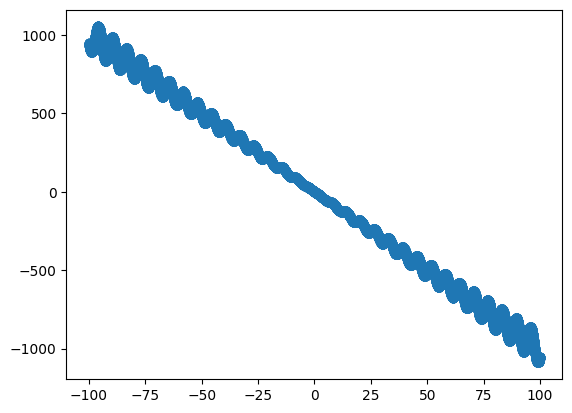

In [1]:
import numpy as np
from numpy import ndarray
import matplotlib.pyplot as plt

# sin(𝑥)𝑥−𝑥10
def f_x (x: ndarray):
    return x*np.sin(x)-10*x

delta_x=0.01
x = list()
y = list()
for i in range(-10000,10000):
    xtr = i*delta_x
    x.append(xtr)
    y.append(f_x(xtr))
x=np.array(x)
y=np.array(y)

plt.plot(x,y)
plt.scatter(x,y)


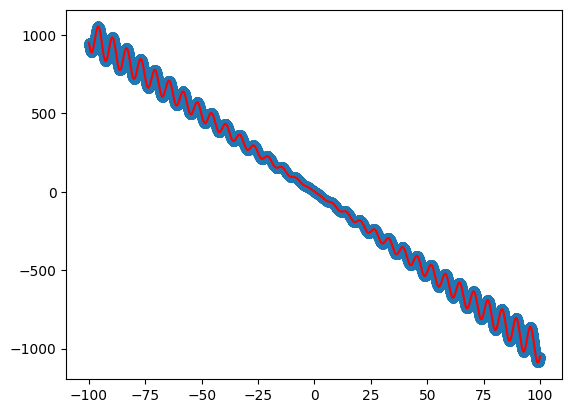

In [2]:


VECTOR_SIZE=64
VECTOR_NUM=1000
    
X = np.random.uniform(-100,100,(VECTOR_NUM,VECTOR_SIZE))
Y = f_x (X)

plt.scatter(X,Y)
plt.plot(x,y,color='red')


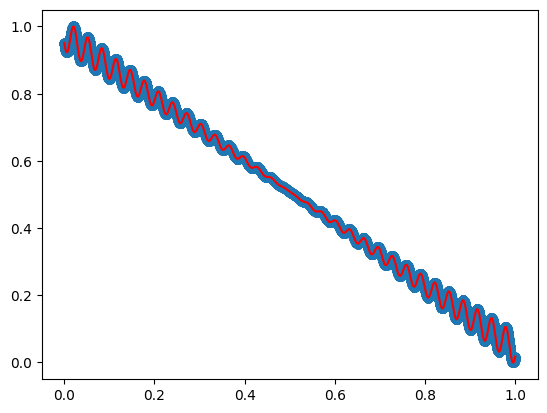

In [3]:
def rescale (array: ndarray):
    array = array-np.min(array)
    array = array/np.max(array)
    return array

x = rescale(x)
y = rescale(y)
X = rescale(X)
Y = rescale(Y)

plt.scatter(X,Y)
plt.plot(x,y,color='red')

In [4]:
GEN_SIZE=8

XG = np.random.uniform(0.0,1.0,(VECTOR_NUM,GEN_SIZE))
XG


array([[0.65388888, 0.45118882, 0.91530703, ..., 0.81425296, 0.84556669,
        0.1164124 ],
       [0.96692361, 0.25254841, 0.9853126 , ..., 0.17722831, 0.74101282,
        0.92386474],
       [0.2879512 , 0.95560845, 0.32175179, ..., 0.76448638, 0.60411593,
        0.59585984],
       ...,
       [0.3146718 , 0.98327262, 0.27210682, ..., 0.8952102 , 0.02785547,
        0.37395694],
       [0.52116568, 0.54948412, 0.94568412, ..., 0.93000874, 0.74404375,
        0.34256175],
       [0.43784332, 0.79646319, 0.44467459, ..., 0.38902474, 0.2731346 ,
        0.00841357]])

In [5]:
import math
import torch
from torch import nn
from torch import optim
import torch.nn.functional as F


class P2ScaleGenerator(nn.Module):

    def __init__(self, input_size, output_size, batch_norm_enabled=True):
        super(P2ScaleGenerator,self).__init__()
        
        # Making the basic perceptron:---------------------------------
        self.layers=[]
        dropout_base = 0.05
        layer_quantity = int(math.log2(output_size)-math.log2(input_size))
        
        for cnt in range(0,layer_quantity):
            coef = math.pow(2,cnt)
            input_vector_size=int(coef*input_size)
            node_number=int(2*coef*input_size)
            #print (input_vector_size,node_number)
            self.layers.append(nn.Linear(input_vector_size,node_number))
            if batch_norm_enabled == True:
                self.layers.append(nn.BatchNorm1d(node_number))

        # Registering modules for torch:-------------------------------
        for cnt,layer in enumerate(self.layers):
            self.add_module("layer{}".format(cnt),layer)

    def forward(self, xtr):
        for cnt,layer in enumerate(self.layers):
            xtr = F.relu(layer(xtr))
            # if cnt<len(self.layers)-1:
            #     xtr = F.relu(layer(xtr))
            # else :
            #     xtr = F.sigmoid(layer(xtr))
        return xtr


In [6]:

# This class was copied from the previous task-3:---------------------------------------

class Perceptron(nn.Module):
    
    def __init__(self, input_size, hidden_size, output_size, hidden_layer_quantity, batch_norm_enabled=True):
        
        super().__init__()
        self.layers = []
        dropout_base = 0.05
        input_size = int(input_size)
        hidden_size = int(hidden_size)
        output_size = int(output_size)
        hidden_layer_quantity = int(hidden_layer_quantity)
        
        # Making the basic perceptron:---------------------------------
        self.layers.append(nn.Linear(input_size,hidden_size))
        self.layers.append(nn.Dropout( dropout_base ))
        
        for cnt in range(0,hidden_layer_quantity):
            self.layers.append(nn.Linear(hidden_size,hidden_size))
            if batch_norm_enabled == True:
                self.layers.append(nn.BatchNorm1d(hidden_size))
            drop_coef = (1.0/hidden_layer_quantity) * cnt + 2*dropout_base
            drop_coef = 0.80 if drop_coef>0.80 else drop_coef
            self.layers.append(nn.Dropout( drop_coef ))
        self.layers.append(nn.Linear(hidden_size,output_size))

        # Registering modules for torch:-------------------------------
        for cnt,layer in enumerate(self.layers):
            key = "layer{}".format(cnt)
            self.add_module(key,layer)

    def forward(self, xtr):
        for cnt,layer in enumerate(self.layers):
            if cnt<len(self.layers)-1:
                xtr = F.leaky_relu(layer(xtr))
            else :
                xtr = F.sigmoid(layer(xtr))
        return xtr


In [7]:
#pip install torchsummary

In [8]:
#from torchsummary import summary

generator = P2ScaleGenerator(input_size=GEN_SIZE, output_size=VECTOR_SIZE)
print (generator)

discriminator = Perceptron(input_size=VECTOR_SIZE, hidden_size=VECTOR_SIZE/8, output_size=1, hidden_layer_quantity=1)
print(discriminator)

#gen_optimizer = torch.optim.SGD(generator.parameters(),lr=0.005,momentum=0.009)

gen_optimizer = torch.optim.Adam(
    generator.parameters(),
    lr=0.001,
    betas=(0.3, 0.99)
)
#dis_optimizer = torch.optim.SGD(discriminator.parameters(),lr=0.005,momentum=0.009)

dis_optimizer = torch.optim.Adam(
    discriminator.parameters(),
    lr=0.001,
    betas=(0.3, 0.99)
)

loss_function = nn.MSELoss(reduction='sum') #torch.nn.BCELoss()

real_y_batch=torch.from_numpy(Y.astype(dtype='float32'))
gen_x_batch=torch.from_numpy(XG.astype(dtype='float32'))



P2ScaleGenerator(
  (layer0): Linear(in_features=8, out_features=16, bias=True)
  (layer1): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layer2): Linear(in_features=16, out_features=32, bias=True)
  (layer3): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layer4): Linear(in_features=32, out_features=64, bias=True)
  (layer5): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)
Perceptron(
  (layer0): Linear(in_features=64, out_features=8, bias=True)
  (layer1): Dropout(p=0.05, inplace=False)
  (layer2): Linear(in_features=8, out_features=8, bias=True)
  (layer3): BatchNorm1d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layer4): Dropout(p=0.1, inplace=False)
  (layer5): Linear(in_features=8, out_features=1, bias=True)
)


In [9]:
#from IPython.display import display, clear_output

true = torch.FloatTensor(VECTOR_NUM, 1).fill_(1.0)
false = torch.FloatTensor(VECTOR_NUM, 1).fill_(0.0)

discriminator_history=[]
generator_history=[]

# fig = plt.figure()
# ax = fig.add_subplot(111)

def generate_noise():
    xg = np.random.uniform(0.0,1.0,(VECTOR_NUM,GEN_SIZE))
    gen_x_batch=torch.from_numpy(xg.astype(dtype='float32'))
    return gen_x_batch

for epoch_num in range(100000):

    gen_input = generate_noise()
    true_y_pred = discriminator(real_y_batch)
    false_y_pred = discriminator(generator(gen_input))

    true_loss = loss_function(true_y_pred,true)
    false_loss = loss_function(false_y_pred,false)
    overall_loss = true_loss+false_loss
    discriminator_history.append(overall_loss.item())
    dis_optimizer.zero_grad()
    if epoch_num%100==0:
        overall_loss.backward()
        dis_optimizer.step()

    false_y_pred = discriminator(generator(gen_input))
    overall_loss = loss_function(false_y_pred,true)
    generator_history.append(overall_loss.item())
    gen_optimizer.zero_grad()
    overall_loss.backward()
    gen_optimizer.step()

    if epoch_num%1000==0:
        #fig.canvas.draw()
        # ax.clear()
        # ax.plot(range(0,epoch_num+1), generator_history,discriminator_history)
        # display(fig)
        # clear_output(wait=True)
        print ("  --> Epoch {} gen {} vs dis {}".format(epoch_num,generator_history[epoch_num],discriminator_history[epoch_num]))



  --> Epoch 0 gen 153.8552703857422 vs dis 528.250732421875
  --> Epoch 1000 gen 114.9949951171875 vs dis 579.669677734375
  --> Epoch 2000 gen 121.1766357421875 vs dis 571.4239501953125
  --> Epoch 3000 gen 125.34565734863281 vs dis 566.885009765625
  --> Epoch 4000 gen 131.42453002929688 vs dis 558.9908447265625
  --> Epoch 5000 gen 136.70970153808594 vs dis 553.8746337890625
  --> Epoch 6000 gen 148.7080078125 vs dis 544.3609008789062
  --> Epoch 7000 gen 151.84983825683594 vs dis 537.105712890625
  --> Epoch 8000 gen 178.57225036621094 vs dis 509.2477111816406
  --> Epoch 9000 gen 162.77151489257812 vs dis 532.472412109375
  --> Epoch 10000 gen 163.05487060546875 vs dis 533.5524291992188
  --> Epoch 11000 gen 169.2054443359375 vs dis 529.2130737304688
  --> Epoch 12000 gen 174.31378173828125 vs dis 524.114501953125
  --> Epoch 13000 gen 180.76983642578125 vs dis 518.8856201171875
  --> Epoch 14000 gen 188.3511505126953 vs dis 514.8805541992188
  --> Epoch 15000 gen 192.699920654296

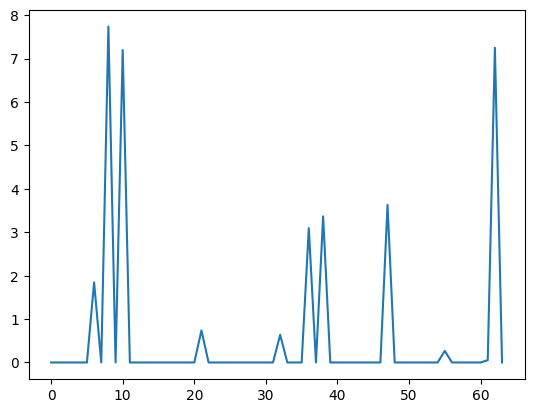

In [21]:
x=generate_noise()
y=generator(x).detach().numpy()
#print(y.shape)
#x=x.detach().numpy()
plt.plot(y[1,])